In [131]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd
import seaborn as sns
import pickle
import cvxpy
from cvxpy import *
from sklearn.preprocessing import Normalizer 
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from copy import deepcopy

In [2]:
# plt.style.use('default')
plt.rcParams.update({'font.size':18})
figDir = '/Users/aqib/Desktop/UCSB/research/BCCL/structured-dmd/NSBA_submission/figures/'
my_cmap = sns.diverging_palette(15, 221, s=99, sep=1, l=45, center='light',as_cmap=True)
# sns.choose_diverging_palette()

In [3]:
def snapshots_from_df(df):

    strains = ['wt','icar','phlf','nand']
    tps = ['5','18']
    temps = ['30','37']
    inducers = ['00','10','01','11']

    # create a dictionary where you specify strain, temp, and inducers as keys to grab the snapshot matrices
    snapshot_dict = {}
    for strain in strains: 
        snapshot_dict[strain] = {}
        for temp in temps: 
            snapshot_dict[strain][temp] = {}
            for inducer in inducers: 
                snapshot_dict[strain][temp][inducer] = {} # keys are to be Yf and Yp
                # get substring of colname that identifies the group (so everything except rep number)
                yp_colname = strain + '_' + inducer + temp + tps[0]
                # get list of indices that correspond to this group (in short, grabbing inds for all replicates)
                yp_col_inds = [ii for ii, this_col in enumerate(list(df.columns)) if yp_colname in this_col]
                snapshot_dict[strain][temp][inducer]['Yp'] = np.array(df.iloc[:,yp_col_inds])
                # do the same for the 18 hours timepoint i.e. Yf
                yf_colname = strain + '_' + inducer + temp + tps[1]
                yf_col_inds = [ii for ii, this_col in enumerate(list(df.columns)) if yf_colname in this_col]
                snapshot_dict[strain][temp][inducer]['Yf'] = np.array(df.iloc[:,yf_col_inds])
                
    return snapshot_dict

def get_unpaired_samples(df):
    # filter the samples that don't have a timepoint pair due to low sequencing depth
    unpaired_samples = []
    for sample in df.columns: 
        if '5' in sample:
            if sample.replace('5','18') not in df.columns:
#                 print(sample,sample.replace('5','18'))
                unpaired_samples.append(sample)
        elif '18' in sample: 
            if sample.replace('18','5') not in df.columns:
#                 print(sample,sample.replace('18','5'))
                unpaired_samples.append(sample)
    return unpaired_samples

def apply_normalizer(Yp,Yf):
    # normalize each datapoint individually
    transformer1 = Normalizer().fit(Yp.T)
    Yp_normed = transformer1.transform(Yp.T).T

    transformer2 = Normalizer().fit(Yf.T)
    Yf_normed = transformer2.transform(Yf.T).T
    return Yp_normed,Yf_normed

In [4]:
def calc_Koopman(Yf,Yp,flag=1,lambda_val=0.0,noise_scaler=1,verbose=True):
    
    ngenes = Yf.shape[0]
    ndatapts = Yf.shape[1]
    
    if flag == 1: # least-squares solution
        Yp_inv = np.linalg.pinv(Yp)
        K = np.dot(Yf,Yp_inv)
        print('The mean squared error is: ' + '{:0.3e}'.format(np.linalg.norm(K@Yp - Yf)**2 / ndatapts)) 

        # TO DO: Add SVD based DMD for modal decompostion (modes can be insightful)
        
    if flag == 2: # robust optimization approach
        
        solver_instance = cvxpy.SCS
                
        operator = Variable(shape=(ngenes,ngenes)) # Koopman matrix  K
        
        if type(lambda_val) == float:
            reg_term = lambda_val * cvxpy.norm(operator,p=1) 
        else:
            lambda_val = np.reshape(lambda_val,(len(lambda_val),1))
            Unoise = np.tile(lambda_val,ndatapts)
            reg_term = cvxpy.norm(cvxpy.matmul(operator + np.eye(ngenes),noise_scaler*Unoise),p='fro') # where exactly does this term come from? 

        print("[INFO]: CVXPY Koopman operator variable: " + repr(operator.shape))
        print("[INFO]: Shape of Yf and Yp: " + repr(Yf.shape) + ', ' + repr(Yp.shape) )
        norm2_fit_term = cvxpy.norm(Yf - cvxpy.matmul(operator,Yp),p=2) 
        objective = Minimize(norm2_fit_term + reg_term)
        constraints = []
        prob = Problem(objective,constraints)
        result = prob.solve(verbose=verbose,solver=solver_instance,max_iters=int(1e6))
        print("[INFO]: CVXPY problem status: " + prob.status)
        K = operator.value
        print('MSE =  ' + '{:0.3e}'.format(np.linalg.norm(K@Yp - Yf)**2 / ndatapts)) 

    return K

#### Reproducing lac and ara host dynamics analysis from BioCAS paper

In [132]:
# load relevant dataframes
df_cts_filter = pd.read_csv('data/count_matrix_NAND.csv')
unpaired_samples = get_unpaired_samples(df_cts_filter)
all_genes_filter =  df_cts_filter['gene']
df_tpm_filter = (pd.read_csv('data/TPM_matrix_NAND.csv')).iloc[:,1:]
df_tpm_filter = df_tpm_filter.drop(columns=unpaired_samples).reset_index(drop=True)

In [133]:
# get ara and lac genes
lac_inds = [ii for ii,this_gene in enumerate(all_genes_filter) if 'lac' in this_gene]
ara_inds = [ii for ii,this_gene in enumerate(all_genes_filter) if 'ara' in this_gene]
lac_genes = [this_gene for ii,this_gene in enumerate(all_genes_filter) if 'lac' in this_gene]
ara_genes = [this_gene for ii,this_gene in enumerate(all_genes_filter) if 'ara' in this_gene]
print(ara_genes+lac_genes)
my_genes = ara_genes + lac_genes
my_inds = ara_inds + lac_inds

['araA', 'araB', 'araC', 'araD', 'araE', 'araF', 'araG', 'araH', 'araJ', 'lacA', 'lacI', 'lacY', 'lacZ']


In [134]:
# get the snapshots
snapshot_dict = snapshots_from_df(df_tpm_filter)

Yp = snapshot_dict['wt']['37']['11']['Yp']
Yf = snapshot_dict['wt']['37']['11']['Yf']

# subset to keep only the desired genes
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
Yp_normed, Yf_normed = Yp_normed[my_inds], Yf_normed[my_inds]

[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.67e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.23e-01  7.48e-01  5.56e-02 -5.78e-02  1.04e-03  5.79e-17  2.36e-03 
    14| 1.21e-11  1.24e-11  1.86e-12 -9.97e-13  8.65e-13  5.11e-18  4.

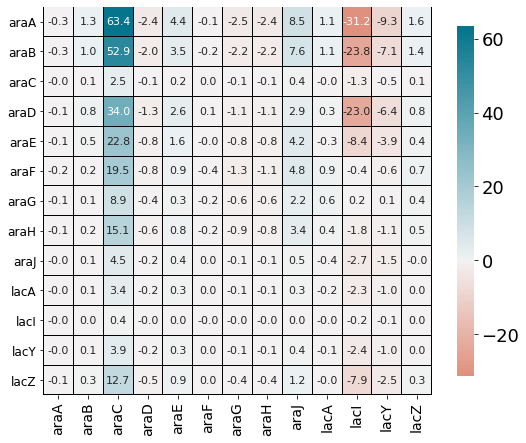

In [8]:
# compute the noise (of the noise), where was this motivated from?
lambda_val_vec_p = np.expand_dims(np.std(Yp_normed,axis=1),axis=1)
lambda_val_vec_f = np.expand_dims(np.std(Yf_normed,axis=1),axis=1)
lambda_val_vec = np.std(np.hstack( (lambda_val_vec_p,lambda_val_vec_f)),axis=1)

K = calc_Koopman(Yf_normed,Yp_normed,flag=2,lambda_val=lambda_val_vec,noise_scaler=1)

######## Visualize host-interactions as heatmap ############
fig = plt.figure(figsize=(8,6.5))
hm = sns.heatmap(K,linewidths=0.005,cmap=my_cmap,xticklabels=my_genes,yticklabels=my_genes,
            linecolor='k',square=True,annot=True,annot_kws={"size":11},fmt='2.1f',cbar_kws={'shrink':0.9},
           center=0)
plt.xticks(fontsize=14,rotation='vertical'); plt.yticks(fontsize=12,rotation='horizontal')
plt.tight_layout()
plt.show()

In [9]:
# get colormap for the learned K 
vcenter = 0
vmin, vmax = K.min(), K.max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
scalarmappable = cm.ScalarMappable(norm=normalize,cmap=my_cmap)
scalarmappable.set_array(K)

- How does LASSO do in terms of sparsity?

In [ ]:
K = calc_Koopman(Yf_normed,Yp_normed,flag=2,lambda_val=0.001,verbose=False)

######## Visualize host-interactions as heatmap ############
fig = plt.figure(figsize=(8,6.5))
hm = sns.heatmap(K,linewidths=0.005,cmap=my_cmap,xticklabels=my_genes,yticklabels=my_genes,
            linecolor='k',square=True,annot=True,annot_kws={"size":11},fmt='2.1f',cbar_kws={'shrink':0.9},
           center=0)
plt.xticks(fontsize=14,rotation='vertical'); plt.yticks(fontsize=12,rotation='horizontal')
plt.tight_layout()
plt.show()

In [ ]:
vcenter = 0
vmin, vmax = K.min(), K.max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
scalarmappable_lasso = cm.ScalarMappable(norm=normalize,cmap=my_cmap)
scalarmappable_lasso.set_array(K)

#### Compare robust DMD to DMD with lasso penalization
- To do this, we will run a leave-one-out experiment and report the average test error for each of the two model types with varying magnitude of regularization

In [135]:
# ndatapts - 1  train/test splits
kf = KFold(n_splits=Yp_normed.shape[1])

In [136]:
# perform robust optimization as \lambda is varied. consider the average test MSE over the learned models
noise_scaler_list = list(np.logspace(-3,3,100))
avg_val_MSE = []
for noise_scaler in noise_scaler_list: 
    val_MSE_list = []
    for train_index, test_index in kf.split(Yp_normed.T):
        print("TRAIN:", train_index, "TEST:", test_index)
        Yp_train, Yp_test = Yp_normed[:,train_index], Yp_normed[:,test_index]
        Yf_train, Yf_test = Yf_normed[:,train_index], Yf_normed[:,test_index]
        # compute the noise (of the noise), where was this motivated from? 
        lambda_val_vec_p = np.expand_dims(np.std(Yp_train,axis=1),axis=1)
        lambda_val_vec_f = np.expand_dims(np.std(Yf_train,axis=1),axis=1)
        lambda_val_vec = np.std(np.hstack( (lambda_val_vec_p,lambda_val_vec_f)),axis=1)
        K = calc_Koopman(Yf_train,Yp_train,flag=2,lambda_val=lambda_val_vec,noise_scaler=noise_scaler,
                         verbose=False)
        val_MSE = mean_squared_error(Yf_test,K@Yp_test)
#         val_MSE = np.linalg.norm(K@Yp_test - Yf_test)**2/(Yp_test.shape[1])
        val_MSE_list.append(val_MSE)
        print('Validation MSE = ' + '{:0.3e}'.format(val_MSE) )
        print('-'*50)
    avg_val_MSE.append(np.mean(val_MSE_list))
    print('Average validation MSE = ' + '{:0.3e}'.format(avg_val_MSE[0]) )


TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  1.006e-23
Validation MSE = 3.443e-04
--------------------------------------------------
TRAIN: [0 2] TEST: [1]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  7.823e-23
Validation MSE = 1.679e-03
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  4.848e-23
Validation MSE = 6.688e-05
--------------------------------------------------
Average validation MSE = 6.967e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman operator variable: (13, 13

WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  2.870e-23
Validation MSE = 3.443e-04
--------------------------------------------------
TRAIN: [0 2] TEST: [1]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  7.898e-23
Validation MSE = 1.710e-03
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  3.537e-23
Validation MSE = 6.632e-05
--------------------------------------------------
Average validation MSE = 6.967e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem st

WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  9.477e-23
Validation MSE = 1.860e-03
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  4.647e-24
Validation MSE = 2.996e-05
--------------------------------------------------
Average validation MSE = 6.967e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  4.897e-24
Validation MSE = 3.456e-04
--------------------------------------------------
TRAIN: [0 2] TEST: [1]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem st

WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  3.419e-23
Validation MSE = 3.561e-04
--------------------------------------------------
TRAIN: [0 2] TEST: [1]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  3.626e-23
Validation MSE = 2.198e-03
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  3.937e-24
Validation MSE = 6.386e-06
--------------------------------------------------
Average validation MSE = 6.967e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem st

WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  4.326e-23
Validation MSE = 7.487e-06
--------------------------------------------------
Average validation MSE = 6.967e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  2.354e-23
Validation MSE = 3.809e-04
--------------------------------------------------
TRAIN: [0 2] TEST: [1]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  9.340e-24
Validation MSE = 2.504e-03
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem st

[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  1.687e-24
Validation MSE = 3.812e-04
--------------------------------------------------
TRAIN: [0 2] TEST: [1]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  4.208e-24
Validation MSE = 2.694e-03
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  9.599e-24
Validation MSE = 1.114e-05
--------------------------------------------------
Average validation MSE = 6.967e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf a

WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  1.976e-23
Validation MSE = 3.702e-04
--------------------------------------------------
TRAIN: [0 2] TEST: [1]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  1.010e-24
Validation MSE = 2.696e-03
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  5.419e-23
Validation MSE = 3.399e-05
--------------------------------------------------
Average validation MSE = 6.967e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem st

WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  1.724e-23
Validation MSE = 2.475e-03
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  2.702e-22
Validation MSE = 1.883e-04
--------------------------------------------------
Average validation MSE = 6.967e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  9.534e-23
Validation MSE = 3.550e-04
--------------------------------------------------
TRAIN: [0 2] TEST: [1]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem st

WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  3.117e-18
Validation MSE = 5.850e-04
--------------------------------------------------
TRAIN: [0 2] TEST: [1]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  2.569e-22
Validation MSE = 2.723e-03
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  1.681e-23
Validation MSE = 3.008e-04
--------------------------------------------------
Average validation MSE = 6.967e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem st

WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  8.917e-23
Validation MSE = 3.036e-04
--------------------------------------------------
Average validation MSE = 6.967e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  9.150e-23
Validation MSE = 1.156e-03
--------------------------------------------------
TRAIN: [0 2] TEST: [1]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  3.944e-22
Validation MSE = 3.553e-03
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem st

[INFO]: CVXPY problem status: optimal
MSE =  8.372e-23
Validation MSE = 3.036e-04
--------------------------------------------------
Average validation MSE = 6.967e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  4.465e-23
Validation MSE = 1.156e-03
--------------------------------------------------
TRAIN: [0 2] TEST: [1]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  8.862e-22
Validation MSE = 3.805e-03
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
WARN: m less than n, problem likely degenerate
[INFO]: CVXPY problem status: optimal
MSE =  7.935e-23
Validation MSE =

In [137]:
# perform lasso regression as \lambda is varied. consider the average test MSE over the learned models
noise_scaler_list = list(np.logspace(-3,3,100))
avg_val_MSE_lasso = []
for noise_scaler in noise_scaler_list: 
    val_MSE_list = []
    for train_index, test_index in kf.split(Yp_normed.T):
        print("TRAIN:", train_index, "TEST:", test_index)
        Yp_train, Yp_test = Yp_normed[:,train_index], Yp_normed[:,test_index]
        Yf_train, Yf_test = Yf_normed[:,train_index], Yf_normed[:,test_index]
        K = calc_Koopman(Yf_train,Yp_train,flag=2,lambda_val=float(noise_scaler),verbose=False)
        val_MSE = mean_squared_error(Yf_test,K@Yp_test)
#         val_MSE = np.linalg.norm(K@Yp_test - Yf_test)**2/(Yp_test.shape[1])
        val_MSE_list.append(val_MSE)
        print('Validation MSE = ' + '{:0.3e}'.format(val_MSE) )
        print('-'*50)
    avg_val_MSE_lasso.append(np.mean(val_MSE_list))
    print('Average validation MSE = ' + '{:0.3e}'.format(avg_val_MSE_lasso[0]) )

TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  1.034e-10
Validation MSE = 4.383e-04
--------------------------------------------------
TRAIN: [0 2] TEST: [1]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  4.397e-10
Validation MSE = 3.534e-04
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  1.544e-10
Validation MSE = 1.674e-04
--------------------------------------------------
Average validation MSE = 3.197e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  2.834e-10
Validation MSE = 4.374e-04
------------

[INFO]: CVXPY problem status: optimal
MSE =  1.997e-03
Validation MSE = 3.034e-04
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  3.468e-03
Validation MSE = 2.856e-04
--------------------------------------------------
Average validation MSE = 3.197e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  1.002e-05
Validation MSE = 4.604e-04
--------------------------------------------------
TRAIN: [0 2] TEST: [1]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  2.550e-03
Validation MSE = 3.376e-04
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]

[INFO]: CVXPY problem status: optimal
MSE =  5.226e-03
Validation MSE = 2.245e-04
--------------------------------------------------
Average validation MSE = 3.197e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  4.247e-05
Validation MSE = 4.647e-04
--------------------------------------------------
TRAIN: [0 2] TEST: [1]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  7.052e-03
Validation MSE = 3.504e-04
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  8.380e-03
Validation MSE = 4.444e-04
--------------------------------------------------
Average validation MSE = 3.197e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman

[INFO]: CVXPY problem status: optimal
MSE =  5.822e-02
Validation MSE = 5.983e-03
--------------------------------------------------
Average validation MSE = 3.197e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  7.187e-02
Validation MSE = 3.882e-03
--------------------------------------------------
TRAIN: [0 2] TEST: [1]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  6.412e-02
Validation MSE = 5.074e-03
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  5.822e-02
Validation MSE = 5.983e-03
--------------------------------------------------
Average validation MSE = 3.197e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman

[INFO]: CVXPY problem status: optimal
MSE =  5.822e-02
Validation MSE = 5.983e-03
--------------------------------------------------
Average validation MSE = 3.197e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  7.187e-02
Validation MSE = 3.882e-03
--------------------------------------------------
TRAIN: [0 2] TEST: [1]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  6.412e-02
Validation MSE = 5.074e-03
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  5.822e-02
Validation MSE = 5.983e-03
--------------------------------------------------
Average validation MSE = 3.197e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman

[INFO]: CVXPY problem status: optimal
MSE =  5.822e-02
Validation MSE = 5.983e-03
--------------------------------------------------
Average validation MSE = 3.197e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  7.187e-02
Validation MSE = 3.882e-03
--------------------------------------------------
TRAIN: [0 2] TEST: [1]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  6.412e-02
Validation MSE = 5.074e-03
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  5.822e-02
Validation MSE = 5.983e-03
--------------------------------------------------
Average validation MSE = 3.197e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman

[INFO]: CVXPY problem status: optimal
MSE =  6.412e-02
Validation MSE = 5.074e-03
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  5.822e-02
Validation MSE = 5.983e-03
--------------------------------------------------
Average validation MSE = 3.197e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  7.187e-02
Validation MSE = 3.882e-03
--------------------------------------------------
TRAIN: [0 2] TEST: [1]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  6.412e-02
Validation MSE = 5.074e-03
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]

[INFO]: CVXPY problem status: optimal
MSE =  5.822e-02
Validation MSE = 5.983e-03
--------------------------------------------------
Average validation MSE = 3.197e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  7.187e-02
Validation MSE = 3.882e-03
--------------------------------------------------
TRAIN: [0 2] TEST: [1]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  6.412e-02
Validation MSE = 5.074e-03
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  5.822e-02
Validation MSE = 5.983e-03
--------------------------------------------------
Average validation MSE = 3.197e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman

[INFO]: CVXPY problem status: optimal
MSE =  6.412e-02
Validation MSE = 5.074e-03
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  5.822e-02
Validation MSE = 5.983e-03
--------------------------------------------------
Average validation MSE = 3.197e-04
TRAIN: [1 2] TEST: [0]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  7.187e-02
Validation MSE = 3.882e-03
--------------------------------------------------
TRAIN: [0 2] TEST: [1]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 2), (13, 2)
[INFO]: CVXPY problem status: optimal
MSE =  6.412e-02
Validation MSE = 5.074e-03
--------------------------------------------------
TRAIN: [0 1] TEST: [2]
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]

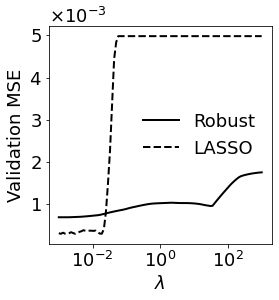

In [145]:
plt.figure(figsize=(4,4))
plt.rcParams.update({'font.size':18})
plt.plot(noise_scaler_list,avg_val_MSE,lw=2,label='Robust',color='k')
plt.plot(noise_scaler_list,avg_val_MSE_lasso,lw=2,label='LASSO',color='k',linestyle='--')
plt.xlabel(r'$\lambda$')
plt.ylabel('Validation MSE')
plt.legend(frameon=False)
plt.xscale('log')
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0),useMathText=True)
# plt.savefig(figDir+'fig2/robust_lasso_comparison.pdf',bbox_inches='tight',dpi=300,transparent=True)
plt.show()

In [ ]:
noise_scaler_list = list(np.linspace(1e-3,1e3,250))
K_list = [] # was easier this way for plotting purposes, though have the tensor of K's is more intuitive
K_tensor = np.zeros((len(my_genes),len(my_genes),len(noise_scaler_list)))
MSE_list = []
for ii,noise_scaler in enumerate(noise_scaler_list):
    K = calc_Koopman(Yf_normed,Yp_normed,flag=2,lambda_val=lambda_val_vec,noise_scaler=noise_scaler)
    K_list.append(K)
    K_tensor[:,:,ii] = K
    mse = np.linalg.norm(K@Yp_normed - Yf_normed)**2/Yp_normed.shape[1]
    MSE_list.append(mse)

#### Build empirical distribution over $\lambda$

- First, robust optimization

In [10]:
# compute the noise (of the noise), where was this motivated from?
lambda_val_vec_p = np.expand_dims(np.std(Yp_normed,axis=1),axis=1)
lambda_val_vec_f = np.expand_dims(np.std(Yf_normed,axis=1),axis=1)
lambda_val_vec = np.std(np.hstack( (lambda_val_vec_p,lambda_val_vec_f)),axis=1)

noise_scaler_list = list(np.logspace(-3,3,1000))
K_list = [] # was easier this way for plotting purposes, though have the tensor of K's is more intuitive
K_tensor = np.zeros((len(my_genes),len(my_genes),len(noise_scaler_list)))
MSE_list = []
for ii,noise_scaler in enumerate(noise_scaler_list):
    K = calc_Koopman(Yf_normed,Yp_normed,flag=2,lambda_val=lambda_val_vec,noise_scaler=noise_scaler)
    K_list.append(K)
    K_tensor[:,:,ii] = K
    mse = np.linalg.norm(K@Yp_normed - Yf_normed)**2/Yp_normed.shape[1]
    MSE_list.append(mse)

[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.70e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.87e-01  6.67e-01  3.56e-02 -3.65e-02  4.55e-04  6.47e-17  1.23e-03 
    12| 1.16e-11  2.18e-12  2.80e-12  5.38e-13  3.34e-12  2.41e-17  2.

----------------------------------------------------------------------------
c'x = 0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  3.191e-24
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.11e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
-----------------------------------------------------------------

----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 4.14e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.87e-01  6.67e-01  3.57e-02 -3.65e-02  4.54e-04  6.45e-17  2.84e-03 
    11| 8.30e-12  4.24e-11  1.03e-12  6.90e-14  1.09e-12  1.77e-17  4.88e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 4.90e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 4.82e-06s
	Cones: avg projection time: 9.08e-05s
	Acceleration: avg step time: 2.

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.87e-01  6.68e-01  3.57e-02 -3.66e-02  4.54e-04  6.44e-17  3.48e-02 
    12| 9.53e-12  1.09e-11  1.64e-12  9.82e-13  2.62e-12  3.34e-17  3.69e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.69e-02s
	Lin-sys: nnz in L factor: 1573, avg solve time: 4.05e-06s
	Cones: avg projection time: 7.83e-05s
	Acceleration: avg step time: 2.42e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.7888e-12, dist(y, K*) = 6.6832e-12, s'y/|s||y| = 3.6571e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 9.5274e-12
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.0941e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.6398e-12
----------------------

----------------------------------------------------------------------------
c'x = -0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  2.262e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 3.40e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 4.60e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.87e-01  6.68e-01  3.58e-02 -3.67e-02  4.54e-04  6.41e-17  2.51e-03 
    11| 1.03e-11  6.88e-11  1.82e-12 -1.02e-12  8.09e-13  2.36e-17  4.42e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.80e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.88e-01  6.69e-01  3.59e-02 -3.68e-02  4.54e-04  6.39e-17  2.55e-02 
    12| 1.11e-11  1.20e-11  1.55e-12 -1.42e-12  1.24e-13  1.41e-18  2.77e-02 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 3.81e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.88e-01  6.70e-01  3.60e-02 -3.69e-02  4.54e-04  6.36e-17  3.22e-03 
    11| 1.28e-11  6.70e-11  6.09e-13 -1.20e-12 -5.92e-13  1.41e-17  5.30e-03 
----------------------------------------------------------------------------
Status: So

    16| 9.22e-12  3.55e-11  1.17e-12  8.75e-13 -2.95e-13  5.87e-17  8.21e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 8.22e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.42e-06s
	Cones: avg projection time: 6.67e-05s
	Acceleration: avg step time: 1.97e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 4.1513e-12, dist(y, K*) = 2.4259e-11, s'y/|s||y| = -1.2177e-01
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 9.2233e-12
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.5523e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.1692e-12
----------------------------------------------------------------------------
c'x = 0.0000, -b'y = -0.0000
[INFO]: CVXPY problem status: optimal
MSE =  6.958e-24
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
--------------------------------------------------------------------------

    14| 1.09e-11  2.18e-11  2.81e-12  6.96e-13  3.51e-12  6.07e-17  6.11e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 6.12e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 2.85e-06s
	Cones: avg projection time: 5.84e-05s
	Acceleration: avg step time: 1.35e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 4.2013e-12, dist(y, K*) = 5.1614e-12, s'y/|s||y| = -2.4004e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.0894e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.1783e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.8114e-12
----------------------------------------------------------------------------
c'x = 0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  5.021e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
---------------------------------------------------------------------------

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.47e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.90e-01  6.72e-01  3.64e-02 -3.73e-02  4.53e-04  6.26e-17  5.48e-02 
    17| 1.28e-11  1.02e-11  4.08e-12 -6.55e-13  3.43e-12  1.95e-17  5.67e-02 
----------------------------------------------------------------------------
Status: So

[INFO]: CVXPY problem status: optimal
MSE =  5.151e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.14e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.90e-01  6.73e-01  3.64e-02 -3.74e-02  4.53e-04  6.24e-17  1.29e-03 
    14| 7.93e-1

----------------------------------------------------------------------------
     0| 1.90e-01  6.73e-01  3.64e-02 -3.74e-02  4.54e-04  6.25e-17  4.24e-02 
    12| 1.15e-11  2.80e-11  4.33e-12  6.99e-13 -3.64e-12  2.65e-18  4.41e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 4.41e-02s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.99e-06s
	Cones: avg projection time: 7.30e-05s
	Acceleration: avg step time: 1.93e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 4.5287e-12, dist(y, K*) = 4.8405e-12, s'y/|s||y| = -3.0211e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.1459e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.8020e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.3344e-12
----------------------------------------------------------------------------
c'x = 0.0000, -b'y = -0.0000
[INFO]: CVXPY problem status: optimal
MSE =  2.907e-23
[INFO]: CVXPY 

MSE =  3.556e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 2.10e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.90e-01  6.73e-01  3.65e-02 -3.74e-02  4.55e-04  6.25e-17  1.88e-03 
    11| 1.37e-11  5.48e-11  1.66e-12  1.44e-12 -2.14e

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 2.19e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.90e-01  6.73e-01  3.65e-02 -3.74e-02  4.57e-04  6.26e-17  2.96e-03 
    12| 1.10e-11  2.02e-11  6.94e-13  1.83e-12  1.13e-12  6.99e-18  4.80e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 4.42e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.07e-06s
	Cones: avg projection time: 7.15e-05s
	Acceleration: avg step time: 1.44e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 4.2033e-12, dist(y, K*) = 2.4462e-11, s'y/|s||y| = 4.3347e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 9.7266e-12
dual res:   |A'y + c|_2 / (1 + |c|_2) = 4.9072e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.6943e-12
----------------------------------------------------------------------------
c'x = 0.0000, -b'y = -0.0000
[INFO]: CVXPY problem status: optimal
MSE =  6.192e-24
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford Unive

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 2.14e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.90e-01  6.73e-01  3.66e-02 -3.75e-02  4.62e-04  6.26e-17  2.73e-03 
    13| 9.63e-12  2.79e-11  1.47e-12  1.75e-12  2.80e-13  4.00e-17  4.99e-03 
----------------------------------------------------------------------------
Status: So

[INFO]: CVXPY problem status: optimal
MSE =  4.445e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 5.07e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.90e-01  6.73e-01  3.66e-02 -3.75e-02  4.65e-04  6.25e-17  3.17e-03 
    11| 1.37e-1

    13| 9.48e-12  4.11e-11  3.03e-13  4.20e-13  7.23e-13  2.11e-17  3.89e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.90e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 2.86e-06s
	Cones: avg projection time: 5.74e-05s
	Acceleration: avg step time: 1.36e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.9534e-12, dist(y, K*) = 3.2084e-11, s'y/|s||y| = 4.4671e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 9.4786e-12
dual res:   |A'y + c|_2 / (1 + |c|_2) = 4.1115e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.0301e-13
----------------------------------------------------------------------------
c'x = 0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  6.931e-24
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------

[INFO]: CVXPY problem status: optimal
MSE =  2.662e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 4.32e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.91e-01  6.74e-01  3.67e-02 -3.77e-02  4.72e-04  6.23e-17  8.41e-03 
    11| 1.70e-1

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.11e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.91e-01  6.74e-01  3.68e-02 -3.78e-02  4.76e-04  6.22e-17  2.12e-03 
    13| 1.87e-11  5.27e-11  4.66e-12  1.35e-13 -4.52e-12  8.48e-18  3.57e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 2.52e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.91e-01  6.75e-01  3.69e-02 -3.78e-02  4.80e-04  6.19e-17  1.63e-03 
    14| 9.38e-12  6.12e-12  1.55e-12 -6.64e-13  8.86e-13  1.92e-17  3.27e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.96e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.91e-01  6.75e-01  3.70e-02 -3.79e-02  4.84e-04  6.17e-17  1.56e-03 
    12| 1.58e-11  4.17e-11  3.65e-12 -3.52e-12  1.26e-13  4.92e-17  3.10e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 2.77e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.92e-01  6.76e-01  3.71e-02 -3.80e-02  4.88e-04  6.15e-17  2.41e-03 
    13| 1.49e-11  1.81e-11  2.99e-12  6.74e-13 -2.32e-12  2.85e-17  4.33e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 4.34e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.45e-06s
	Cones: avg projection time: 6.36e-05s
	Acceleration: avg step time: 1.

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 2.14e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.92e-01  6.77e-01  3.72e-02 -3.81e-02  4.92e-04  6.12e-17  2.40e-03 
    11| 8.94e-12  5.15e-11  9.36e-13 -1.38e-13  7.98e-13  2.40e-17  4.86e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 2.21e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.93e-01  6.78e-01  3.73e-02 -3.82e-02  4.97e-04  6.09e-17  1.47e-03 
    11| 1.46e-11  2.07e-11  7.75e-12 -2.54e-13  7.50e-12  6.03e-17  3.38e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
     0| 1.93e-01  6.79e-01  3.74e-02 -3.83e-02  5.02e-04  6.05e-17  1.85e-03 
    13| 7.62e-12  8.00e-12  3.83e-12 -2.93e-12  8.99e-13  2.98e-17  4.52e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 4.54e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.07e-06s
	Cones: avg projection time: 7.31e-05s
	Acceleration: avg step time: 1.81e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 4.1661e-12, dist(y, K*) = 2.5362e-11, s'y/|s||y| = -1.5297e-01
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 7.6158e-12
dual res:   |A'y + c|_2 / (1 + |c|_2) = 7.9952e-12
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.8334e-12
----------------------------------------------------------------------------
c'x = -0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  7.337e-24
[INFO]: CVXPY 

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.12e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.94e-01  6.80e-01  3.75e-02 -3.85e-02  5.08e-04  6.01e-17  5.67e-03 
    11| 8.70e-12  8.20e-12  4.15e-13 -2.13e-13 -6.28e-13  1.44e-17  9.72e-03 
----------------------------------------------------------------------------
Status: So

    11| 1.32e-11  3.72e-11  4.44e-12 -1.69e-12  2.75e-12  2.32e-17  4.98e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 4.99e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.35e-06s
	Cones: avg projection time: 6.16e-05s
	Acceleration: avg step time: 1.47e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 5.9729e-12, dist(y, K*) = 2.0435e-11, s'y/|s||y| = -1.1366e-01
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.3185e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.7205e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.4397e-12
----------------------------------------------------------------------------
c'x = -0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  1.578e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
--------------------------------------------------------------------------

----------------------------------------------------------------------------
c'x = -0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  2.432e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 2.51e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.95e-01  6.83e-01  3.79e-02 -3.88e-02  5.40e-04  5.92e-17  4.44e-02 
    11| 1.40e-11  6.30e-11  1.64e-12  1.56e-14 -1.63e-12  6.56e-17  4.59e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 4.59e-02s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.45e-06s
	Cones: avg projection time: 7.27e-05s
	Acceleration: avg step time: 1.85e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 5.8518e-12, dist(y, K*) = 4.0605e-11, s'y/|s||y| = -1.6924e-01
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.4044e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.2971e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.6417e-12
---------------------

----------------------------------------------------------------------------
c'x = -0.0000, -b'y = -0.0000
[INFO]: CVXPY problem status: optimal
MSE =  6.712e-24
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.61e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
---------------------------------------------------------------

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.95e-01  6.83e-01  3.80e-02 -3.89e-02  5.54e-04  5.91e-17  3.91e-02 
    12| 1.41e-11  5.20e-11  7.20e-12 -1.92e-12  5.28e-12  2.74e-18  4.08e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 4.08e-02s
	Lin-sys: nnz in L factor: 1573, avg solve time: 4.09e-06s
	Cones: avg projection time: 7.32e-05s
	Acceleration: avg step time: 1.85e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.0632e-12, dist(y, K*) = 3.3837e-11, s'y/|s||y| = 6.3655e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.4100e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 5.2041e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 7.2049e-12
----------------------

----------------------------------------------------------------------------
c'x = 0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  4.960e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 2.51e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
-----------------------------------------------------------------

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.96e-01  6.84e-01  3.81e-02 -3.90e-02  5.72e-04  5.88e-17  2.16e-02 
    13| 1.58e-11  2.31e-11  6.56e-13 -7.55e-13 -9.83e-14  2.21e-17  2.50e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.50e-02s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.20e-06s
	Cones: avg projection time: 6.09e-05s
	Acceleration: avg step time: 1.51e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 5.4204e-12, dist(y, K*) = 2.8325e-11, s'y/|s||y| = 4.0318e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.5819e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.3051e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 6.5624e-13
----------------------

----------------------------------------------------------------------------
c'x = -0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  2.064e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 2.07e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------

----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 5.2804e-12, dist(y, K*) = 3.2866e-11, s'y/|s||y| = 1.8117e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.8241e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.2316e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.4415e-12
----------------------------------------------------------------------------
c'x = 0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  4.865e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variable

[INFO]: CVXPY problem status: optimal
MSE =  1.535e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 3.11e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.97e-01  6.87e-01  3.84e-02 -3.94e-02  6.02e-04  5.78e-17  8.99e-03 
    12| 8.88e-1

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 7.01e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.98e-01  6.88e-01  3.86e-02 -3.95e-02  6.12e-04  5.74e-17  5.80e-03 
    12| 1.34e-11  3.76e-11  2.71e-12  3.53e-12  8.21e-13  2.33e-17  8.16e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.15e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.99e-01  6.90e-01  3.87e-02 -3.97e-02  6.23e-04  5.68e-17  6.25e-02 
    11| 1.15e-11  2.30e-11  5.25e-13  4.98e-13 -2.78e-14  5.56e-18  6.37e-02 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
c'x = 0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  5.137e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.81e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
-----------------------------------------------------------------

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.72e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.00e-01  6.94e-01  3.91e-02 -4.00e-02  6.41e-04  5.57e-17  3.97e-02 
    12| 1.24e-11  4.27e-11  2.37e-12  3.06e-12  6.91e-13  8.72e-18  4.14e-02 
----------------------------------------------------------------------------
Status: So

    12| 1.38e-11  1.16e-11  2.60e-12  4.62e-13  3.07e-12  2.42e-17  3.61e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.62e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.31e-06s
	Cones: avg projection time: 6.50e-05s
	Acceleration: avg step time: 1.52e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.5599e-12, dist(y, K*) = 2.7873e-11, s'y/|s||y| = -1.4546e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.3774e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.1628e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.6029e-12
----------------------------------------------------------------------------
c'x = 0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  3.327e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
---------------------------------------------------------------------------

----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 8.41e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 4.65e-06s
	Cones: avg projection time: 6.32e-05s
	Acceleration: avg step time: 1.55e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.7412e-12, dist(y, K*) = 2.9252e-12, s'y/|s||y| = 1.1188e-01
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.4255e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.0784e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 8.8199e-13
----------------------------------------------------------------------------
c'x = -0.0000, -b'y = -0.0000
[INFO]: CVXPY problem status: optimal
MSE =  4.025e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford Univ

Setup time: 3.58e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.03e-01  7.01e-01  3.97e-02 -4.07e-02  6.65e-04  5.38e-17  1.65e-03 
    15| 1.40e-11  2.88e-11  2.86e-12 -5.24e-13  2.34e-12  4.88e-17  3.75e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.77e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.17e-06s
	Cones: avg projection time: 6.19e-05s
	Acceleration: avg step time: 1.54e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 6.6767e-12, dist(y, K*) = 3.8879e-11, s'y/|s||y| = 7.0714e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.3961e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.8848e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.8631e-12


    20| 1.85e-11  1.89e-11  2.35e-12 -2.18e-12  1.72e-13  1.30e-17  1.07e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.07e-02s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.15e-06s
	Cones: avg projection time: 6.63e-05s
	Acceleration: avg step time: 1.59e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.2346e-11, dist(y, K*) = 4.2365e-11, s'y/|s||y| = -1.0064e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.8507e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.8906e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.3550e-12
----------------------------------------------------------------------------
c'x = -0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  2.653e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
--------------------------------------------------------------------------

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 4.70e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.05e-01  7.06e-01  4.02e-02 -4.12e-02  6.83e-04  5.27e-17  2.55e-03 
    15| 8.17e-12  3.46e-11  1.88e-12  1.24e-12 -6.35e-13  3.71e-17  4.96e-03 
----------------------------------------------------------------------------
Status: So

[INFO]: CVXPY problem status: optimal
MSE =  3.856e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 6.44e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.06e-01  7.07e-01  4.05e-02 -4.15e-02  6.92e-04  5.23e-17  5.56e-03 
    12| 1.08e-1

----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.17e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 2.99e-06s
	Cones: avg projection time: 6.02e-05s
	Acceleration: avg step time: 1.33e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.6940e-12, dist(y, K*) = 2.3604e-11, s'y/|s||y| = -9.7954e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.0501e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.1770e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.1033e-12
----------------------------------------------------------------------------
c'x = -0.0000, -b'y = -0.0000
[INFO]: CVXPY problem status: optimal
MSE =  2.922e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford Uni

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 5.02e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.07e-01  7.09e-01  4.08e-02 -4.18e-02  7.18e-04  5.23e-17  1.40e-03 
    18| 5.15e-12  1.14e-11  1.84e-12  1.07e-12 -7.69e-13  1.41e-17  3.81e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.66e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.67e-06s
	Cones: avg projection time: 7.59e-05s
	Acceleration: avg step time: 1.78e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.0314e-12, dist(y, K*) = 2.9825e-09, s'y/|s||y| = 7.7820e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.4301e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 5.2341e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 7.1191e-13
----------------------------------------------------------------------------
c'x = -0.0000, -b'y = -0.0000
[INFO]: CVXPY problem status: optimal
MSE =  1.495e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford Univ

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 2.63e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.08e-01  7.11e-01  4.14e-02 -4.24e-02  7.48e-04  5.21e-17  2.60e-03 
    20| 1.81e-11  6.20e-12  6.43e-13 -6.47e-13 -4.08e-15  1.08e-17  5.70e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 4.49e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.05e-06s
	Cones: avg projection time: 6.25e-05s
	Acceleration: avg step time: 1.47e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 4.5777e-12, dist(y, K*) = 1.1246e-10, s'y/|s||y| = -9.9417e-03
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.2607e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.0778e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.3444e-13
----------------------------------------------------------------------------
c'x = 0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  7.536e-24
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford Unive

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.71e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.09e-01  7.13e-01  4.18e-02 -4.28e-02  7.65e-04  5.20e-17  3.60e-03 
    13| 1.44e-11  4.64e-12  1.70e-13  1.37e-13 -3.29e-14  9.61e-18  6.09e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.23e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.09e-01  7.15e-01  4.22e-02 -4.33e-02  7.81e-04  5.21e-17  4.98e-03 
    11| 1.85e-11  4.63e-11  1.43e-11 -8.37e-13 -1.51e-11  1.71e-17  6.77e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.8681e-12, dist(y, K*) = 3.4328e-10, s'y/|s||y| = 3.4881e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.1996e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 4.0184e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.0036e-12
----------------------------------------------------------------------------
c'x = -0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  2.568e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variabl

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.09e-01  7.15e-01  4.28e-02 -4.39e-02  8.08e-04  5.26e-17  2.83e-03 
    17| 1.41e-11  8.82e-12  3.44e-13  2.70e-13 -7.38e-14  2.48e-17  6.01e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 6.02e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.36e-06s
	Cones: avg projection time: 7.21e-05s
	Acceleration: avg step time: 1.73e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 5.8191e-12, dist(y, K*) = 6.0183e-10, s'y/|s||y| = -2.3761e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.4110e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 8.8175e-12
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.4430e-13
---------------------

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 8.22e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.09e-01  7.16e-01  4.33e-02 -4.44e-02  8.27e-04  5.32e-17  7.51e-03 
    11| 1.17e-11  1.70e-11  2.46e-12 -1.45e-13  2.31e-12  1.48e-22  1.05e-02 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 6.35e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.10e-01  7.16e-01  4.36e-02 -4.47e-02  8.39e-04  5.35e-17  1.29e-03 
     9| 1.27e-11  2.27e-11  1.15e-12 -1.57e-13  9.96e-13  2.59e-18  2.36e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.37e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.32e-06s
	Cones: avg projection time: 6.77e-05s
	Acceleration: avg step time: 1.

----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.8164e-12, dist(y, K*) = 1.2513e-10, s'y/|s||y| = -6.0320e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 9.8110e-12
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.3909e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 8.7937e-12
----------------------------------------------------------------------------
c'x = -0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  2.128e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variab

     0| 2.10e-01  7.17e-01  4.46e-02 -4.58e-02  8.79e-04  5.44e-17  2.30e-03 
    11| 9.53e-12  3.73e-11  2.45e-12 -1.39e-12  1.06e-12  1.82e-17  4.51e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 4.53e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.51e-06s
	Cones: avg projection time: 7.03e-05s
	Acceleration: avg step time: 1.84e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 6.0605e-12, dist(y, K*) = 9.3850e-10, s'y/|s||y| = -1.7750e-01
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 9.5334e-12
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.7344e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.4474e-12
----------------------------------------------------------------------------
c'x = -0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  1.098e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13,

----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.5146e-12, dist(y, K*) = 8.5733e-10, s'y/|s||y| = 3.0766e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 7.8910e-12
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.6434e-12
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.5930e-12
----------------------------------------------------------------------------
c'x = 0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  1.565e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variable

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 2.10e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.10e-01  7.19e-01  4.58e-02 -4.70e-02  9.23e-04  5.53e-17  4.28e-03 
    14| 1.15e-11  3.15e-11  2.34e-13  2.31e-13  4.65e-13  2.50e-18  6.35e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.11e-01  7.21e-01  4.65e-02 -4.78e-02  9.43e-04  5.56e-17  1.20e-02 
    15| 1.37e-11  3.49e-11  1.49e-13  9.95e-13  1.14e-12  1.16e-17  1.47e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.54e-02s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.17e-06s
	Cones: avg projection time: 7.23e-05s
	Acceleration: avg step time: 1.79e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 4.2328e-12, dist(y, K*) = 1.3385e-10, s'y/|s||y| = -9.3653e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.3734e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.4921e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.4909e-13
---------------------

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 4.07e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.12e-01  7.22e-01  4.72e-02 -4.86e-02  9.64e-04  5.58e-17  3.90e-03 
    20| 6.42e-12  1.43e-11  2.36e-12  2.04e-12 -3.23e-13  1.33e-17  7.84e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 5.93e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.13e-01  7.26e-01  4.82e-02 -4.97e-02  9.81e-04  5.61e-17  5.95e-03 
    13| 1.42e-11  1.22e-11  5.94e-13  7.83e-13  1.89e-13  5.59e-18  9.60e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.15e-01  7.30e-01  4.97e-02 -5.13e-02  9.96e-04  5.64e-17  2.91e-02 
    11| 1.55e-11  4.77e-11  4.62e-12 -1.08e-12 -5.70e-12  3.11e-21  3.07e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.07e-02s
	Lin-sys: nnz in L factor: 1573, avg solve time: 4.01e-06s
	Cones: avg projection time: 7.92e-05s
	Acceleration: avg step time: 2.32e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.2449e-12, dist(y, K*) = 5.2176e-10, s'y/|s||y| = 1.6238e-01
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.5532e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 4.7655e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.6204e-12
----------------------

----------------------------------------------------------------------------
c'x = 0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  2.856e-24
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.24e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
-----------------------------------------------------------------

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.19e-01  7.39e-01  5.24e-02 -5.43e-02  1.02e-03  5.70e-17  5.59e-02 
     9| 1.10e-11  2.63e-11  1.03e-13  1.39e-12  1.49e-12  1.42e-17  5.85e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 5.85e-02s
	Lin-sys: nnz in L factor: 1573, avg solve time: 6.07e-06s
	Cones: avg projection time: 1.24e-04s
	Acceleration: avg step time: 2.69e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.6312e-12, dist(y, K*) = 1.2665e-10, s'y/|s||y| = -9.2509e-03
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.1019e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.6272e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.0287e-13
---------------------

----------------------------------------------------------------------------
c'x = -0.0000, -b'y = -0.0000
[INFO]: CVXPY problem status: optimal
MSE =  6.376e-24
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.02e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
---------------------------------------------------------------

 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.22e-01  7.46e-01  5.48e-02 -5.70e-02  1.03e-03  5.76e-17  3.44e-02 
    15| 1.17e-11  8.31e-12  3.92e-13  3.21e-13  7.13e-13  5.38e-18  3.63e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.63e-02s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.19e-06s
	Cones: avg projection time: 6.15e-05s
	Acceleration: avg step time: 1.56e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.7627e-12, dist(y, K*) = 7.9236e-11, s'y/|s||y| = -3.2805e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.1696e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 8.3060e-12
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.9182e-13
----------------------------------------------------------------------------
c'x = 0.0000, -b'y = 

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 2.05e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.24e-01  7.50e-01  5.64e-02 -5.88e-02  1.05e-03  5.82e-17  2.76e-03 
    12| 1.01e-11  3.47e-11  1.43e-12  8.13e-13  2.24e-12  1.12e-17  5.05e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.16e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.25e-01  7.55e-01  5.81e-02 -6.07e-02  1.07e-03  5.89e-17  3.30e-03 
    13| 1.74e-11  4.10e-11  3.62e-12  1.89e-12 -1.73e-12  4.26e-19  5.52e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 3.85e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.28e-01  7.60e-01  6.01e-02 -6.28e-02  1.09e-03  5.96e-17  9.50e-03 
    13| 1.75e-11  5.62e-11  3.56e-12  1.41e-12 -2.15e-12  1.83e-17  1.27e-02 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 4.04e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.30e-01  7.66e-01  6.23e-02 -6.53e-02  1.11e-03  6.02e-17  2.71e-03 
    11| 8.07e-12  6.16e-12  3.42e-12 -9.72e-13  2.45e-12  4.73e-21  4.95e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 5.53e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.35e-01  7.78e-01  6.61e-02 -6.97e-02  1.12e-03  6.13e-17  7.45e-03 
    11| 1.45e-11  3.43e-11  1.97e-12 -3.06e-12 -1.09e-12  2.00e-17  1.00e-02 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.05e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.39e-01  7.86e-01  6.88e-02 -7.28e-02  1.14e-03  6.21e-17  5.91e-02 
    11| 1.37e-11  3.97e-11  1.59e-12 -2.27e-12 -6.82e-13  2.00e-17  6.03e-02 
----------------------------------------------------------------------------
Status: So

[INFO]: CVXPY problem status: optimal
MSE =  3.428e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.56e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.46e-01  8.01e-01  7.38e-02 -7.85e-02  1.16e-03  6.34e-17  2.19e-03 
    14| 1.58e-1

     0| 2.52e-01  8.16e-01  7.86e-02 -8.41e-02  1.18e-03  6.47e-17  3.43e-02 
    13| 1.09e-11  1.05e-11  1.67e-12  2.13e-12  4.55e-13  1.64e-17  3.59e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.59e-02s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.26e-06s
	Cones: avg projection time: 6.24e-05s
	Acceleration: avg step time: 1.54e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 4.4979e-12, dist(y, K*) = 1.4309e-10, s'y/|s||y| = 5.5298e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.0923e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.0544e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.6708e-12
----------------------------------------------------------------------------
c'x = 0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  5.308e-24
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 2.82e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.59e-01  8.30e-01  8.29e-02 -8.92e-02  1.20e-03  6.58e-17  3.79e-03 
    20| 1.72e-11  5.66e-11  8.72e-13  2.84e-12  3.71e-12  1.48e-17  6.89e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 4.29e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.66e-01  8.47e-01  8.80e-02 -9.52e-02  1.22e-03  6.70e-17  2.42e-03 
    11| 1.32e-11  3.44e-11  2.72e-12 -1.81e-13 -2.90e-12  1.19e-21  3.98e-03 
----------------------------------------------------------------------------
Status: So

[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 6.75e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.75e-01  8.66e-01  9.36e-02 -1.02e-01  1.25e-03  6.83e-17  6.40e-03 
    17| 1.63e-11  1.89e-12  2.68e-12 -3.11e-13 -2.99e-12  1.12e-17  8.

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 4.08e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.84e-01  8.85e-01  9.92e-02 -1.09e-01  1.27e-03  6.97e-17  3.87e-03 
    15| 1.23e-11  2.32e-11  3.81e-12 -1.21e-12 -5.02e-12  1.50e-17  6.02e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 4.20e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.94e-01  9.07e-01  1.06e-01 -1.17e-01  1.30e-03  7.19e-17  4.12e-03 
    14| 8.80e-12  3.43e-11  3.73e-12  2.33e-12 -1.41e-12  9.68e-18  6.24e-03 
----------------------------------------------------------------------------
Status: So

[INFO]: CVXPY problem status: optimal
MSE =  1.714e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 5.16e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.05e-01  9.31e-01  1.14e-01 -1.27e-01  1.34e-03  7.42e-17  5.74e-03 
    17| 9.70e-1

----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.61e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.10e-06s
	Cones: avg projection time: 6.71e-05s
	Acceleration: avg step time: 1.43e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 7.8284e-12, dist(y, K*) = 2.6277e-10, s'y/|s||y| = -3.7073e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.4511e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 4.7343e-12
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.4763e-12
----------------------------------------------------------------------------
c'x = -0.0000, -b'y = -0.0000
[INFO]: CVXPY problem status: optimal
MSE =  8.700e-24
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford Uni

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 4.57e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.27e-01  9.77e-01  1.28e-01 -1.45e-01  1.40e-03  7.84e-17  1.70e-03 
    17| 1.79e-11  1.38e-11  1.26e-12 -1.03e-12 -2.29e-12  1.93e-17  3.65e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
     0| 3.43e-01  1.01e+00  1.37e-01 -1.58e-01  1.44e-03  8.14e-17  1.85e-03 
    14| 1.08e-11  2.69e-11  7.82e-12 -4.00e-12  3.83e-12  3.00e-17  3.60e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.61e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.17e-06s
	Cones: avg projection time: 6.45e-05s
	Acceleration: avg step time: 1.55e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 8.2760e-12, dist(y, K*) = 5.6119e-11, s'y/|s||y| = -2.2052e-01
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.0820e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.6941e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 7.8232e-12
----------------------------------------------------------------------------
c'x = -0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  4.698e-23
[INFO]: CVXPY 

     0| 3.59e-01  1.04e+00  1.48e-01 -1.72e-01  1.48e-03  8.50e-17  3.51e-03 
    14| 1.24e-11  4.86e-11  1.04e-12 -1.14e-12 -9.73e-14  5.21e-18  5.04e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 5.06e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.38e-06s
	Cones: avg projection time: 6.44e-05s
	Acceleration: avg step time: 1.59e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.5011e-12, dist(y, K*) = 3.2210e-11, s'y/|s||y| = 1.0991e-01
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.2426e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 4.8640e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.0419e-12
----------------------------------------------------------------------------
c'x = -0.0000, -b'y = -0.0000
[INFO]: CVXPY problem status: optimal
MSE =  1.116e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13,

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.60e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.80e-01  1.08e+00  1.61e-01 -1.91e-01  1.54e-03  8.99e-17  3.46e-03 
    13| 1.34e-11  4.58e-11  5.91e-12 -2.58e-12  3.33e-12  6.89e-18  5.87e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 4.40e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.00e-01  1.12e+00  1.75e-01 -2.10e-01  1.60e-03  9.50e-17  2.99e-03 
    13| 1.44e-11  3.71e-11  8.01e-13 -2.73e-12 -1.93e-12  7.53e-18  5.14e-03 
----------------------------------------------------------------------------
Status: So

 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.26e-01  1.17e+00  1.92e-01 -2.36e-01  1.68e-03  1.02e-16  3.63e-03 
    17| 7.36e-12  2.05e-11  3.35e-12  1.10e-12 -2.25e-12  2.49e-17  6.68e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 6.70e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.45e-06s
	Cones: avg projection time: 6.86e-05s
	Acceleration: avg step time: 1.79e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.9202e-13, dist(y, K*) = 4.3544e-11, s'y/|s||y| = 2.0291e-01
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 7.3613e-12
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.0490e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.3482e-12
----------------------------------------------------------------------------
c'x = 0.0000, -b'y = -

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 2.00e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.54e-01  1.23e+00  2.10e-01 -2.64e-01  1.75e-03  1.09e-16  8.33e-03 
    17| 1.52e-11  4.12e-11  5.89e-13 -2.65e-12 -2.06e-12  2.09e-17  1.02e-02 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.16e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.72e-01  1.26e+00  2.22e-01 -2.84e-01  1.80e-03  1.15e-16  1.24e-03 
    14| 8.05e-12  8.63e-12  5.30e-12  1.58e-12 -3.72e-12  2.31e-17  2.62e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 4.56e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 5.03e-01  1.31e+00  2.42e-01 -3.18e-01  1.89e-03  1.24e-16  2.98e-03 
    20| 2.00e-09  8.60e-09  1.71e-09  1.68e-09 -2.94e-11  2.11e-17  5.28e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 9.4806e-12, dist(y, K*) = 2.2596e-09, s'y/|s||y| = 3.0067e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.2048e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.3037e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.1430e-12
----------------------------------------------------------------------------
c'x = 0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  8.408e-24
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variable

[INFO]: CVXPY problem status: optimal
MSE =  2.925e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.88e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 5.77e-01  1.43e+00  2.89e-01 -4.04e-01  2.10e-03  1.48e-16  3.49e-03 
    11| 1.38e-1

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 2.12e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 6.23e-01  1.50e+00  3.15e-01 -4.58e-01  2.23e-03  1.62e-16  2.04e-02 
    12| 1.95e-11  4.31e-12  4.58e-12 -1.98e-12  2.60e-12  2.03e-17  2.29e-02 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 2.35e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 6.79e-01  1.58e+00  3.44e-01 -5.23e-01  2.38e-03  1.79e-16  6.06e-03 
    13| 1.94e-11  1.15e-11  1.31e-11 -2.85e-12  1.02e-11  3.73e-18  8.77e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 3.40e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 7.45e-01  1.68e+00  3.76e-01 -6.01e-01  2.55e-03  1.99e-16  4.50e-03 
    20| 2.73e-11  1.15e-10  5.26e-12 -1.14e-12  4.12e-12  1.31e-18  7.19e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 5.71e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 8.28e-01  1.80e+00  4.12e-01 -6.99e-01  2.75e-03  2.24e-16  4.07e-03 
    19| 1.65e-11  8.00e-11  4.92e-12  2.72e-12  7.64e-12  2.54e-18  7.50e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.10e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 9.27e-01  1.94e+00  4.51e-01 -8.18e-01  3.00e-03  2.53e-16  9.48e-04 
    20| 4.05e-11  1.33e-11  2.35e-11  3.12e-12  2.66e-11  3.72e-18  3.42e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
c'x = -0.0000, -b'y = -0.0000
[INFO]: CVXPY problem status: optimal
MSE =  8.716e-24
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.10e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
---------------------------------------------------------------

----------------------------------------------------------------------------
     0| 1.18e+00  2.27e+00  5.32e-01 -1.14e+00  3.61e-03  3.30e-16  3.87e-02 
    20| 2.48e-11  3.58e-12  1.51e-11 -1.83e-12  1.33e-11  3.31e-17  4.10e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 4.10e-02s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.07e-06s
	Cones: avg projection time: 6.48e-05s
	Acceleration: avg step time: 1.54e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 8.2856e-12, dist(y, K*) = 3.4264e-11, s'y/|s||y| = -5.0088e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.4840e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.5790e-12
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.5118e-11
----------------------------------------------------------------------------
c'x = -0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  1.419e-22
[INFO]: CVXPY 

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.98e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.35e+00  2.47e+00  5.75e-01 -1.35e+00  4.01e-03  3.82e-16  1.95e-03 
    20| 4.53e-11  4.52e-11  6.49e-12  1.52e-13  6.65e-12  2.47e-17  4.42e-03 
----------------------------------------------------------------------------
Status: So

[INFO]: CVXPY problem status: optimal
MSE =  2.507e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 3.76e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.58e+00  2.75e+00  6.24e-01 -1.65e+00  4.55e-03  4.53e-16  2.60e-03 
    20| 5.04e-1

[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 5.17e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.83e+00  3.04e+00  6.67e-01 -2.00e+00  5.14e-03  5.34e-16  3.70e-03 
    10| 9.29e-12  3.44e-11  2.85e-13 -4.13e-13 -1.28e-13  6.74e-17  6.

----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.14e+00  3.38e+00  7.09e-01 -2.43e+00  5.86e-03  6.35e-16  2.79e-03 
    20| 1.22e-11  7.14e-11  1.51e-12  1.32e-12 -1.90e-13  4.29e-17  7.54e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 7.56e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.13e-06s
	Cones: avg projection time: 6.86e-05s
	Acceleration: avg step time: 1.60e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 5.3908e-12, dist(y, K*) = 1.0980e-10, s'y/|s||y| = -1.5222e-01
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.2159e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 7.1357e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.5084e-12
---------------------

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 5.65e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.53e+00  3.80e+00  7.50e-01 -2.99e+00  6.77e-03  7.63e-16  4.61e-03 
    19| 1.59e-11  5.57e-11  2.69e-12 -1.66e-12  1.03e-12  7.98e-17  8.37e-03 
----------------------------------------------------------------------------
Status: So

 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.01e+00  4.32e+00  7.89e-01 -3.72e+00  7.91e-03  9.29e-16  4.75e-03 
    13| 1.72e-11  4.01e-11  1.94e-12  7.43e-14 -1.87e-12  5.41e-17  9.18e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 9.20e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 4.11e-06s
	Cones: avg projection time: 8.13e-05s
	Acceleration: avg step time: 2.32e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 6.6367e-12, dist(y, K*) = 1.0489e-10, s'y/|s||y| = 7.2195e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.7211e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 4.0107e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.9449e-12
----------------------------------------------------------------------------
c'x = 0.0000, -b'y = -

    12| 1.42e-11  6.39e-11  1.31e-11 -8.68e-13  1.22e-11  3.94e-17  7.63e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 7.63e-02s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.16e-06s
	Cones: avg projection time: 6.62e-05s
	Acceleration: avg step time: 1.42e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 6.4648e-12, dist(y, K*) = 3.9340e-11, s'y/|s||y| = 8.9183e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.4228e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.3944e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.3103e-11
----------------------------------------------------------------------------
c'x = -0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  1.911e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
---------------------------------------------------------------------------

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 4.62e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.42e+00  5.79e+00  8.57e-01 -6.01e+00  1.13e-02  1.44e-15  1.88e-03 
    20| 2.01e-11  3.87e-11  6.92e-12  1.51e-12  8.42e-12  6.33e-17  4.60e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.34e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 2.85e-06s
	Cones: avg projection time: 5.96e-05s
	Acceleration: avg step time: 1.38e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.0638e-11, dist(y, K*) = 8.7878e-11, s'y/|s||y| = -7.4924e-03
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 3.8661e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.1244e-10
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.3160e-12
----------------------------------------------------------------------------
c'x = -0.0000, -b'y = -0.0000
[INFO]: CVXPY problem status: optimal
MSE =  9.163e-22
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford Uni

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 3.23e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 6.18e+00  7.59e+00  9.01e-01 -9.07e+00  1.57e-02  2.12e-15  1.62e-03 
    20| 1.69e-11  6.32e-11  2.93e-12 -8.76e-13 -3.81e-12  6.08e-17  3.80e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 5.09e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.24e-06s
	Cones: avg projection time: 6.44e-05s
	Acceleration: avg step time: 1.46e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.0864e-11, dist(y, K*) = 2.1209e-11, s'y/|s||y| = -1.7331e-01
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.4495e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 8.0505e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.7245e-12
----------------------------------------------------------------------------
c'x = 0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  2.672e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford Unive

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 3.15e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.03e+01  1.18e+01  9.43e-01 -1.65e+01  2.62e-02  3.76e-15  1.53e-03 
    17| 9.96e-12  8.93e-11  4.01e-12  3.16e-12 -8.49e-13  1.35e-16  3.50e-03 
----------------------------------------------------------------------------
Status: So

[INFO]: CVXPY problem status: optimal
MSE =  2.184e-22
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 3.02e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.65e+01  1.82e+01  9.66e-01 -2.84e+01  4.25e-02  6.33e-15  2.80e-03 
    20| 1.57e-1

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.10e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.10e+01  3.29e+01  9.83e-01 -5.69e+01  8.10e-02  1.25e-14  3.74e-03 
    20| 4.07e-11  2.61e-12  3.18e-11 -7.55e-14 -3.19e-11  4.29e-17  6.97e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 6.25e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.47e+02  1.51e+02  9.97e-01 -2.88e+02  3.91e-01  6.23e-14  4.28e-03 
    19| 8.41e-12  6.75e-11  2.74e-12  2.09e-12 -6.43e-13  1.61e-16  7.76e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 3.30e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.15e+20  1.15e+20  1.00e+00 -2.45e+20  3.18e+17  3.22e+18  4.68e-03 
    20| 3.92e-11  1.41e-11  3.44e-11 -1.39e-12 -3.58e-11  1.92e-16  8.22e-03 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 5.77e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.16e+20  1.14e+20  1.00e+00 -2.61e+20  3.31e+17  6.35e+18  1.86e-03 
    20| 1.04e-11  2.50e-11  8.64e-12 -1.06e-12 -9.70e-12  7.53e-17  3.97e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 3.99e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.25e-06s
	Cones: avg projection time: 6.78e-05s
	Acceleration: avg step time: 1.

----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 5.1179e-12, dist(y, K*) = 1.5789e-10, s'y/|s||y| = -5.0550e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 5.9665e-12
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.7080e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 8.7795e-13
----------------------------------------------------------------------------
c'x = 0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  2.524e-23
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variabl

----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 4.26e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.19e+20  1.12e+20  1.00e+00 -3.16e+20  3.73e+17  1.71e+19  2.99e-03 
    20| 3.66e-11  2.83e-11  1.84e-11 -1.18e-11  6.62e-12  3.94e-17  6.09e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 6.11e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.28e-06s
	Cones: avg projection time: 7.25e-05s
	Acceleration: avg step time: 1.

----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.4952e-11, dist(y, K*) = 1.1181e-09, s'y/|s||y| = -9.1324e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.5159e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 6.9295e-11
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.2247e-11
----------------------------------------------------------------------------
c'x = 0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  6.870e-22
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variabl

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 2.71e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.22e+20  1.10e+20  1.00e+00 -3.74e+20  4.21e+17  2.82e+19  3.57e-03 
    20| 2.45e-11  4.39e-10  2.27e-11 -1.72e-11  5.54e-12  8.75e-18  6.29e-03 
----------------------------------------------------------------------------
Status: So

eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.67e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.23e+20  1.09e+20  1.00e+00 -4.16e+20  4.60e+17  3.47e+19  3.31e-03 
    20| 2.05e-11  1.38e-10  1.75e-11 -1.72e-11  2.29e-13  2.88e-16  6.33e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 6.35e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.13e-06s
	Cones: avg projection time: 6.83e-05s
	Acceleration: avg step time: 1.60e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.36

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 3.01e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.25e+20  1.09e+20  1.00e+00 -4.64e+20  5.08e+17  4.04e+19  4.15e-03 
    20| 1.22e-11  5.07e-11  2.53e-11 -2.59e-12 -2.79e-11  1.86e-16  8.11e-03 
----------------------------------------------------------------------------
Status: So

[INFO]: CVXPY problem status: optimal
MSE =  2.419e-22
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 3.81e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.26e+20  1.09e+20  1.00e+00 -4.96e+20  5.42e+17  4.40e+19  5.99e-03 
    20| 3.14e-1

----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 5.98e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 2.72e-06s
	Cones: avg projection time: 6.08e-05s
	Acceleration: avg step time: 1.38e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.5208e-11, dist(y, K*) = 1.7555e-10, s'y/|s||y| = 8.4583e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.0653e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.2839e-10
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.6659e-12
----------------------------------------------------------------------------
c'x = -0.0000, -b'y = -0.0000
[INFO]: CVXPY problem status: optimal
MSE =  1.090e-22
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford Univ

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 2.19e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.30e+20  1.08e+20  1.00e+00 -6.16e+20  6.66e+17  5.64e+19  5.52e-03 
    20| 1.52e-11  1.87e-10  1.63e-12  6.30e-12  4.66e-12  2.83e-16  1.02e-02 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
c'x = -0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  1.179e-22
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.25e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 1.24e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.32e+20  1.08e+20  1.00e+00 -7.66e+20  8.22e+17  7.00e+19  5.16e-02 
    20| 8.89e-11  4.12e-09  4.51e-10 -5.32e-10 -8.17e-11  2.37e-16  5.46e-02 
----------------------------------------------------------------------------
Status: So

----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 3.4222e-11, dist(y, K*) = 1.9454e-09, s'y/|s||y| = -2.8611e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 2.4107e-11
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.2599e-10
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.1059e-10
----------------------------------------------------------------------------
c'x = 0.0000, -b'y = -0.0000
[INFO]: CVXPY problem status: optimal
MSE =  2.670e-21
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variab

 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.35e+20  1.09e+20  1.00e+00 -9.40e+20  1.00e+18  8.37e+19  2.52e-02 
    18| 4.31e-12  4.28e-10  9.97e-12 -7.43e-12  2.55e-12  5.80e-17  2.76e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 2.77e-02s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.24e-06s
	Cones: avg projection time: 6.59e-05s
	Acceleration: avg step time: 1.57e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 0.0000e+00, dist(y, K*) = 2.7188e-10, s'y/|s||y| = 1.9920e-01
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 4.3064e-12
dual res:   |A'y + c|_2 / (1 + |c|_2) = 4.2814e-10
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 9.9719e-12
----------------------------------------------------------------------------
c'x = -0.0000, -b'y = 

c'x = 0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  3.896e-21
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 2.17e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.36e+20  1.09e+20  1.00e+00 -1.01e+21  1.07e+18  8.86e+1

    20| 4.67e-12  3.32e-10  3.60e-11  2.21e-12 -3.38e-11  1.20e-16  5.37e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 5.39e-03s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.09e-06s
	Cones: avg projection time: 7.13e-05s
	Acceleration: avg step time: 1.69e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.1561e-11, dist(y, K*) = 8.7249e-10, s'y/|s||y| = -3.7247e-02
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 4.6745e-12
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.3241e-10
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.5966e-11
----------------------------------------------------------------------------
c'x = 0.0000, -b'y = -0.0000
[INFO]: CVXPY problem status: optimal
MSE =  1.999e-22
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
--------------------------------------------------------------------------

    20| 5.26e-12  4.92e-10  5.85e-11 -4.02e-11  1.82e-11  7.50e-17  1.40e-02 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 1.40e-02s
	Lin-sys: nnz in L factor: 1573, avg solve time: 3.17e-06s
	Cones: avg projection time: 6.86e-05s
	Acceleration: avg step time: 1.53e-05s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.1271e-12, dist(y, K*) = 1.3410e-09, s'y/|s||y| = 2.0653e-01
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 5.2600e-12
dual res:   |A'y + c|_2 / (1 + |c|_2) = 4.9162e-10
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 5.8450e-11
----------------------------------------------------------------------------
c'x = -0.0000, -b'y = 0.0000
[INFO]: CVXPY problem status: optimal
MSE =  3.864e-22
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 3), (13, 3)
---------------------------------------------------------------------------

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1031
eps = 1.00e-04, alpha = 1.50, max_iters = 1000000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 171, constraints m = 176
Cones:	soc vars: 40, soc blks: 1
	sd vars: 136, sd blks: 1
Setup time: 6.68e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.39e+20  1.09e+20  1.00e+00 -1.42e+21  1.47e+18  1.14e+20  2.38e-03 
    20| 8.20e-12  1.41e-09  1.20e-11 -1.26e-11 -2.46e-11  1.10e-15  5.37e-03 
----------------------------------------------------------------------------
Status: So

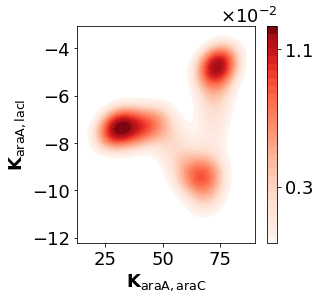

In [129]:
import matplotlib.ticker as tkr
formatter = tkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))

plt.figure(figsize=(4,4))
sns.kdeplot(x=K_tensor[0,2,:],y=K_tensor[0,11,:],shade=True,cmap='Reds',levels=30,cbar=True, \
           cbar_kws={'ticks':[0.0005, 0.003, 0.011],'format':formatter})
plt.xlabel(r'$\mathbf{K}_{\mathrm{araA, araC}}$')
plt.ylabel(r'$\mathbf{K}_{\mathrm{araA, lacI}}$')
# plt.savefig(figDir+'fig2/robust_opt_K_araA_impact.pdf',transparent=True,bbox_inches='tight',dpi=300)
plt.show()

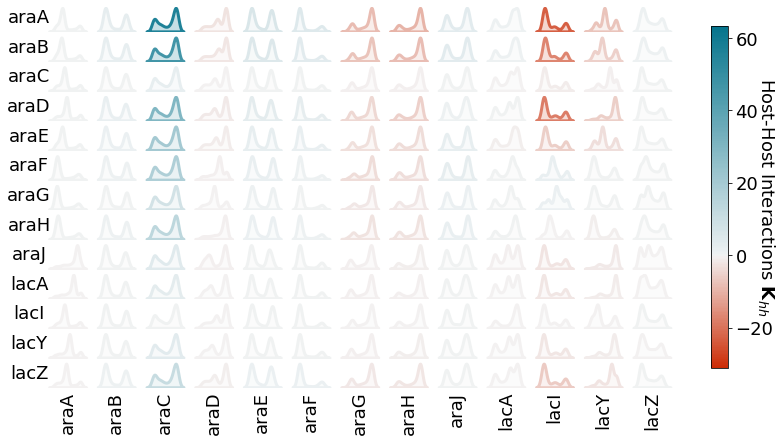

In [95]:
# plt.rcParams.update({'font.size':18})
fig, ax = plt.subplots(K_list[0].shape[0],K_list[0].shape[1],figsize=(14,7),sharey=False,sharex=False)
for ii in range(len(K_tensor)):
    for jj in range(len(K_tensor)):
        # plot Kij as a distribution over regularization parameter
        Kij_all = K_tensor[ii,jj,:] 
        sns.kdeplot(Kij_all,linewidth=3,shade=True,ax=ax[ii,jj],
                    color=scalarmappable.to_rgba(np.mean(Kij_all)))
        ax[ii,jj].set(ylabel=None)
        # apply gene labels
        if jj == 0:
            ax[ii,jj].set_ylabel((my_genes)[ii],rotation='horizontal',fontsize=18)
            ax[ii,jj].yaxis.set_label_coords(-0.45,0.2)
        if ii == len(K_list[0])-1: 
            ax[ii,jj].set_xlabel((ara_genes+lac_genes)[jj],fontsize=18,rotation='vertical')
            
#         ax[ii,jj].tick_params(axis='x',labelsize=14)
#         ax[ii,jj].set_xticks([np.round(np.min(Kij_all),2),np.round(np.max(Kij_all),2)])
#         ax[ii,jj].tick_params(axis='y',labelsize=14)
        ax[ii,jj].set_yticklabels([]); ax[ii,jj].set_xticklabels([]); 
        ax[ii,jj].set_yticks([]); ax[ii,jj].set_xticks([]);
        for side in ax[ii,jj].spines.keys():
                this_side = ax[ii,jj].spines[side]
                this_side.set_visible(False)
            
cbar = plt.colorbar(scalarmappable,ax=ax[:,:],shrink=0.9)
# cbar.set_label(r'Host-Host Interactions $\mathbf{K}_{hh}$',rotation=270)

plt.savefig(figDir+'fig2/robust_opt_K_varyReg.pdf',transparent=True,bbox_inches='tight',dpi=300)
# plt.tight_layout()
plt.show() 

- Now LASSO

In [ ]:
noise_scaler_list = list(np.logspace(-2,-1,250))
K_list = [] # was easier this way for plotting purposes, though have the tensor of K's is more intuitive
K_tensor = np.zeros((len(my_genes),len(my_genes),len(noise_scaler_list)))
MSE_list = []
for ii,noise_scaler in enumerate(noise_scaler_list):
    K = calc_Koopman(Yf_normed,Yp_normed,flag=2,lambda_val=float(noise_scaler),verbose=False)
    K_list.append(K)
    K_tensor[:,:,ii] = K
    mse = np.linalg.norm(K@Yp_normed - Yf_normed)**2/Yp_normed.shape[1]
    MSE_list.append(mse)

In [ ]:
# plt.rcParams.update({'font.size':18})
fig, ax = plt.subplots(K_list[0].shape[0],K_list[0].shape[1],figsize=(15,9),sharey=False,sharex=False)
for ii in range(len(K_tensor)):
    for jj in range(len(K_tensor)):
        # plot Kij as a distribution over regularization parameter
        Kij_all = K_tensor[ii,jj,:] 
        sns.kdeplot(Kij_all,linewidth=3,shade=True,ax=ax[ii,jj],
                    color=scalarmappable.to_rgba(np.mean(Kij_all)))
        ax[ii,jj].set(ylabel=None)
        # apply gene labels
        if jj == 0:
            ax[ii,jj].set_ylabel((my_genes)[ii],rotation='horizontal',fontsize=18)
            ax[ii,jj].yaxis.set_label_coords(-0.45,0.2)
        if ii == len(K_list[0])-1: 
            ax[ii,jj].set_xlabel((ara_genes+lac_genes)[jj],fontsize=18,rotation='vertical')
            
#         ax[ii,jj].tick_params(axis='x',labelsize=14)
#         ax[ii,jj].set_xticks([np.round(np.min(Kij_all),2),np.round(np.max(Kij_all),2)])
#         ax[ii,jj].tick_params(axis='y',labelsize=14)
        ax[ii,jj].set_yticklabels([]); ax[ii,jj].set_xticklabels([]); 
        ax[ii,jj].set_yticks([]); ax[ii,jj].set_xticks([]);
        for side in ax[ii,jj].spines.keys():
                this_side = ax[ii,jj].spines[side]
                this_side.set_visible(False)
            
cbar = plt.colorbar(scalarmappable_lasso,ax=ax[:,:],shrink=0.9)
# cbar.set_label(r'$\mathbf{K}_{hh}$ Host-Host Koopman matrix',rotation=270)

# plt.savefig(figDir+'robust_opt_K_varyReg_xlabeled.pdf',transparent=True,bbox_inches='tight',dpi=300)
# plt.tight_layout()
plt.show() 

In [ ]:
sns.heatmap(K_tensor[:,:,0])